# Word Embeddings and Text Classification 
Goals of this lecture are
* understand word embeddings
* generate and apply word embeddings
* use word embeddings for text classification
* implement CNN-based text-classification in [keras](https://keras.io).

## Overall Picture and Evolution Path

The conventional way of modelling documents in tasks like information-retrieval, document-clustering, document-classification, sentiment-analysis, topic-classification is to represent each document as a **Bag-Of-Word**-vector $$\mathbf{d}_i=(tf_{i,0},tf_{i,1},\ldots tf_{i,|V|}).$$ Each component of this vector corresponds to a single term $j$ of the underlying vocabulary $V$ and the values $tf_{i,j}$ counts the frequency of term $j$ in document $i$. Instead of the term-frequency $tf_{i,j}$ it is also possible to fill the BoW-vector with 
* a binary indicator which indicates if the term $j$ appears in document $i$
* the tf-idf-values $$tfidf_{i,j}=tf_{i,j} \cdot log \frac{N}{df_j},$$ where $df_j$ is the frequency of documents, in which term $j$ appears, and $N$ is the total number of documents.

Independent of the values used, the BoW model represents sets of documents as 2-dimensional numeric arrays, which can easily be passed to conventional Machine Learning algorithms, such as Logistic Regression, SVM, MLPs etc. However, the  
major drawbacks of this approach are:
* the order by which terms appear in the document is totally ignored
* semantic relatedness of terms is not modelled
* BoW- vectors are very long and sparse 

As sketched in the picture below, today all of these drawbacks can be circumvented by representing the words of the document by their word-vectors and passing the corresponding sequence of word vectors in order to either a CNN or a Recurrent Neural Network such as LSTM or GRU. 

<img src="./Pics/overallPicture.png" style="width:600px" align="middle">


---
## Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

## Submission

E-Mail your complete Notebook to [maucher@hdm-stuttgart.de](mailto:maucher@hdm-stuttgart.de) until the start of the next lecture. One Notebook per group is sufficient. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

## Prerequisities

Prepare yourself for this lecture by studying

1. [Jupyter Notebook on Word Embeddings](DSM.ipynb); [.html-Version](). 
1. [30 seconds to keras tutorial](https://keras.io/#getting-started-30-seconds-to-keras).
2. [Text Preprocessing in Keras](https://keras.io/preprocessing/text/)
3. [Word Embeddings in Gensim](https://radimrehurek.com/gensim/models/word2vec.html).

---

## Tasks on Word Embeddings
### Learn Skipgram Word Embedding from German Wikipedia Dump

Word Embeddings for many languages can be downloaded for example from e.g. [FastText](https://fasttext.cc/docs/en/english-vectors.html). After downloading they can be imported into Python as described in [DSM.ipynb].

In this notebook we do not apply an already trained WordEmbedding, but generate our own embedding from the German Wikipedia dump. Training of an own WordEmbedding is recommended in order to adapt the embedding to a specific application domain. Actually a common process is to first train a word embedding with a general corpus (e.g. Wikipedia dump) and then train (fine-tune) with domain-specific texts on top of the pretrained embedding.    

#### Task 1: Download latest version of German Wikipedia dump
The latest version of the German Wikipedia dump can be obtained from [http://download.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2](http://download.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2). The size of this dump is about 4.8 GB.

#### Task 2: Extract and clean Wikipedia dump
For extracting only the relevant information (raw-text) from the downloaded dump the [wikiextractor](https://github.com/attardi/wikiextractor) can be applied. Download and install this Python script. 

Execute this extractor by

`WikiExtractor.py -b 500K -o extracted dewiki-latest-pages-articles.xml.bz2`

Note that this extraction process takes some hours.

#### Task 3: Learn Skipgram Word-Embedding
The class `MySentences`, as defined in the following cell, implements a *generator*, which returns all sentences of the extracted and cleaned wikipedia dump. The argument `dirnameP` is the name of the directory which contains all extracted and cleaned files of the wikipedia dump. This directory has been generated in the previous task. 

**Question:** What is a Phyton *generator*?

In [1]:
class MySentences(object):
    def __init__(self, dirnameP):
        self.dirnameP = dirnameP
 
    def __iter__(self):
        for subdir in os.listdir(self.dirnameP):
            if subdir[0]!=".":
                print(subdir)
                subdirpath=os.path.join(self.dirnameP,subdir)
                print(subdirpath)
                for fname in os.listdir(subdirpath):
                    if fname!="dec":
                        for line in open(os.path.join(subdirpath, fname)):
                            linelist=line.split()
                            if len(linelist)>3 and linelist[0][0]!="<":
                                yield [w.lower().strip(",."" \" () :; ! ?") for w in linelist]



**Answer:**
Generators are a simple way to generate iterators. The main adventage of generators is, that the methods __iter__() and next() were generated automatically. Futhermore generators use yield instead of return. So everytime the yield statement is reached, the generator gets interrupted and retunrns an iterator object. The internal state is captured until the next call oft the generator.

The generator `MySentences` is applied as shown in the following code cell. The generated sentences are passed to *gensim's* `Word2Vec()`-method. This method trains the word embedding. Note that this learning-process takes some hours.

**Question:** Explain the arguments of `Word2Vec()`, which are applied in the code cell below. 

In [2]:
from gensim.models import word2vec
parentDir="./extracted"
modelName="./DataSets/dewiki2018skipgram.model"
try:
    model=word2vec.Word2Vec.load(modelName)
    print("Already existing model is loaded")
except:
    print("Model doesn't exist. Training of word2vec model started.")
    sentences = MySentences(parentDir) # a memory-friendly iterator
    model = word2vec.Word2Vec(sentences,size=200,sorted_vocab=1,sg=1)
model.init_sims(replace=True)
model.save(modelName)#persistently save the learned model. It can be loaded by
                      #model=word2vec.Word2Vec.load(modelName)

/home/pia4/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


Already existing model is loaded


**Answer:**

sentences: Describes the list of split sentences.

size: Describes the dimensionality oft he word vectors.

sorted_vocab: Describes if the vocabulary is sorted by descending or ascending frequency before assigning word indexes. 1 for descendign and 0 for ascending.

sg: Describes the training algorithm which will be used. 1 for skip-gram and 0 for CBOW.

### Using Word Embeddings

#### Task 4: Meta information of the learned Word Embedding
For the learned word2vec-model display the following parameters:
* number of words in the corpus, which has been applied for training
* number of different words in the learned word2vec-model
* time required for training
* count of trainings to generate this model
* length of the word2vec-vectors
* context-length, applied in training the model

In [3]:
# number of words in the corpus, which has been applied for training
model.corpus_total_words

741345629

In [4]:
# number of different words in the learned word2vec-model
len(model.wv.vocab)

2163601

In [5]:
model.wv.vectors.shape

(2163601, 200)

In [6]:
# time required for training in sec. 
model.total_train_time

14097.895074261964

In [7]:
# count of trainings to generate this model
model.train_count

1

In [8]:
# length of the word2vec-vectors
model.wv.vector_size

200

In [9]:
# context-length, applied in training the model

#### Task 5: Access Word Embeddings
Display the first 10 components of the vectors of words
* *hochschule*
* *universität*
* *anstalt*

What do you observe?

In [10]:
vec1 = model.wv['hochschule'] 
print(vec1[:10])

[-0.02239556 -0.02764557  0.02738815 -0.15893547  0.0801862  -0.10483365
  0.0387268  -0.06579254 -0.02685843 -0.06369451]


In [11]:
vec2 = model.wv['universität'] 
print(vec2[:10])

[-0.00971891 -0.06143887 -0.01036509 -0.16941072  0.09410676 -0.03747999
  0.06165719 -0.08384693 -0.03039209 -0.04508238]


In [12]:
vec3 = model.wv['anstalt'] 
print(vec3[:10])

[-0.1258442  -0.19474776  0.1113607  -0.0564578  -0.10027298 -0.06115803
  0.00412503 -0.02557262  0.04491956 -0.1119209 ]


**Observation:**
Here we can see that the vectors of the words hoschule, universität and anstalt are very close. It seems that these three words are word-related.

Display the words (not the word-vectors) at indices 0 to 49 of the Word-embedding. What do you observe?

In [13]:
number_words = 49

for i in range(0,number_words):
    print(model.wv.index2word[i])


der
die
und
in
von
im
den
des
mit
das
er
wurde
dem
als
ist
zu
ein
auf
für
eine
sich
an
war
nach
am
auch
sie
aus
bei
bis
zum
es
einer
durch
einem
werden
sind
nicht
zur
wird
über
einen
um
oder
wurden
unter
dass
wie
jahr


**Observation:**

As we can see, the most frequent words are some kind of filler words. 

### Analyse Word Similarities

In [14]:
model.init_sims(replace=True)#create an index for similarity calculations

#### Task 6: Most similar words
For a German word of your choice, display the 20 most similar words.

In [15]:
model.wv.most_similar('gott', topn=20)

[('gottes', 0.8670438528060913),
 ('jehova', 0.7926334142684937),
 ('logos-sohn', 0.7895896434783936),
 ('göttliche', 0.7870802879333496),
 ('gottessohn', 0.7863912582397461),
 ('jhwh', 0.7853482961654663),
 ('gott“', 0.7837964296340942),
 ('jahwe', 0.7798424959182739),
 ('ratschluss', 0.7797118425369263),
 ('götter', 0.772087812423706),
 ('dreieinen', 0.771276593208313),
 ('ahura', 0.7708321809768677),
 ('dreifaltigen', 0.7684510946273804),
 ('„gott', 0.7681044340133667),
 ('wesenseins', 0.767221987247467),
 ('göttlichen', 0.7668366432189941),
 ('gott.“', 0.76600182056427),
 ('unvergänglichkeit', 0.7644802927970886),
 ('vatergott', 0.7638100385665894),
 ('zorngericht', 0.7636433243751526)]

For a pair of German words of your choice, display their similarity-value.

In [16]:
model.wv.n_similarity("gott", "teufel")

0.8593435

For two sets of German words of your choice, display their similarity-value.

In [17]:
model.wv.n_similarity(["gott", "teufel"], ["wissenschaft"])

0.3968218

#### Task 7: Word Relations
Apply the Word Embedding in order to answer the following questions:
* *Mann is to König as Frau is to ?*
* *Paris is to Frankreich as Berlin is to ?*
* *Student is to Hochschule as Arbeiter is to ?*

In [18]:
model.wv.most_similar(positive=["frau", "könig"], negative=["mann"], topn=3)
#seems to be wrong


[('gemahlin', 0.7083898782730103),
 ('königin', 0.646159291267395),
 ('gattin', 0.644999086856842)]

In [19]:
model.wv.most_similar(positive=["berlin", "frankreich"], negative=["paris"], topn=3)

[('deutschland', 0.7195090055465698),
 ('brandenburg', 0.6283190250396729),
 ('ostdeutschland', 0.6261070966720581)]

In [20]:
model.wv.most_similar(positive=["arbeiter", "hochschule"], negative=["student"], topn=3)

[('werkswohnungen', 0.5696111917495728),
 ('bergarbeiter', 0.5639299154281616),
 ('fabriken', 0.5603055953979492)]

#### Task 8: Outliers
Apply the Word Embedding in order to determine the outlier within the following set of words: *auto, motorrad, kran, essen*. 

In [21]:
model.wv.doesnt_match(["auto", "motorrad", "kran", "essen"])

/home/pia4/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/gensim/models/keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'essen'

### Visualize Word Embeddings
The following code-cell visualizes similarities of words from index 300 to 599 by transforming the high-dimensional word-vectors into a 2-dim space. The transformation is realized by [scikit-learn's TSNE modul](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

/home/pia4/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


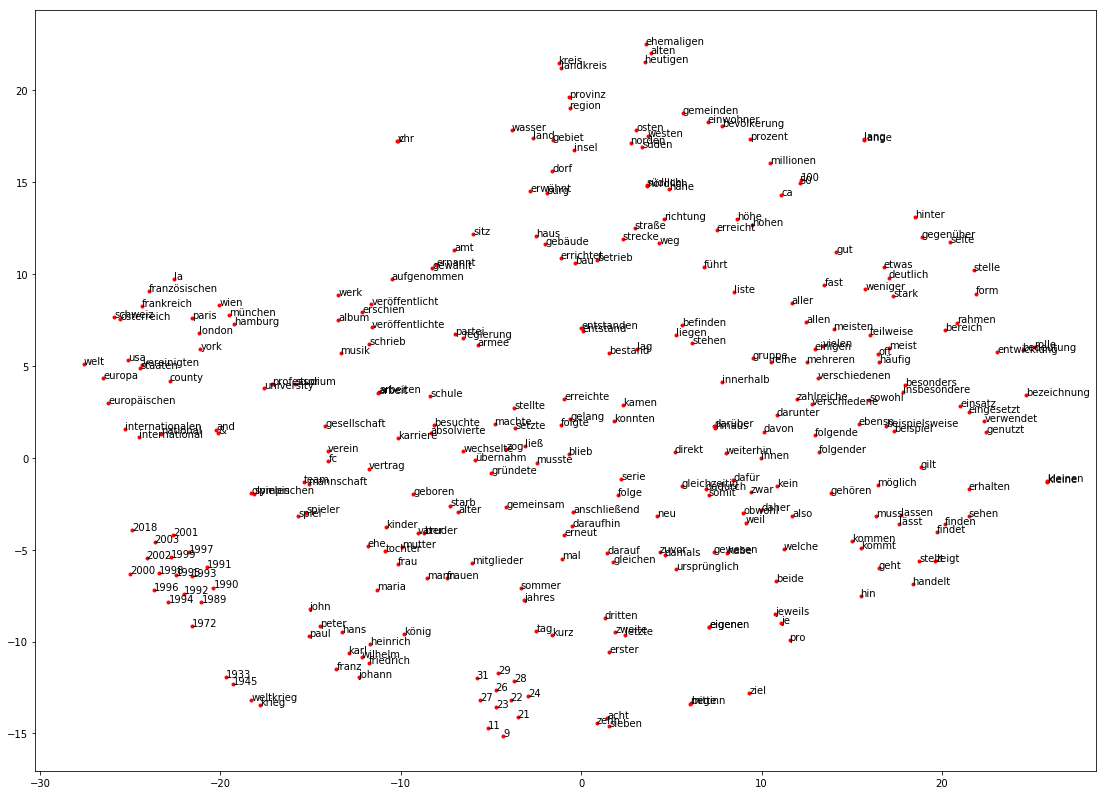

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
tsneModel=TSNE(n_components=2,random_state=0)
np.set_printoptions(suppress=True)
model2d=tsneModel.fit_transform(model[model.wv.index2word[300:600]])



plt.figure(figsize=(19,14))
idx=0
for a in model2d[:300]:
    #w=model.wv.index2word[300+idx].decode('utf-8')
    w=model.wv.index2word[300+idx]
    plt.plot(a[0],a[1],'r.')
    plt.text(a[0],a[1],w)
    idx+=1
plt.show()

#### Task 9: Visualize similarities of selected target words and their neighbors
For each of the word in the list `targetwords` calculate the 10 nearest neighbors. Then apply the same procedure as in the code cell above in order to visualize the similarities between all words in `wordset`, where `wordset` contains the target words and for each target word the 10 nearest neighbors. What do you observe? 

model2d2=tsneModel.fit_transform(model[targetwords])
print(model2d2)

/home/pia4/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


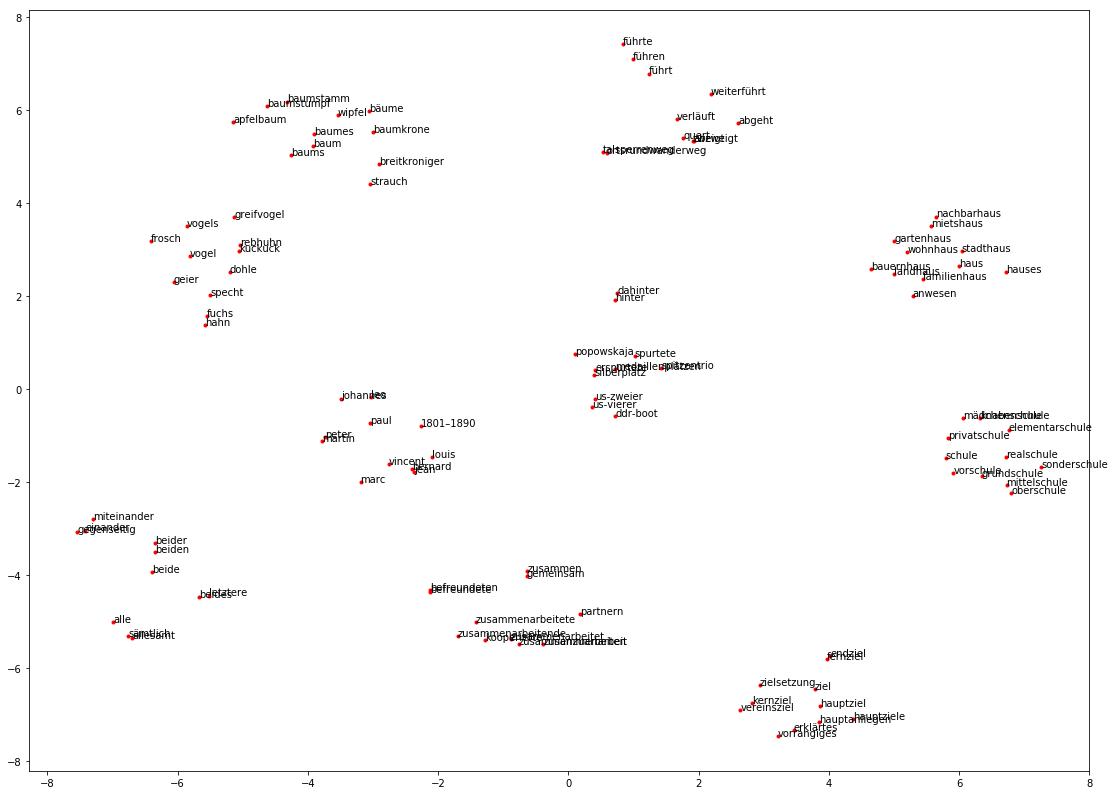

In [23]:
wordset = []
targetwords = ['haus','baum','vogel','schule','gemeinsam','beide','paul','führt','hinter','ziel']

for i in targetwords:
    wordset.append(i)

for word in targetwords:
    neighbors = model.wv.similar_by_word(word, topn=10)
    for n in neighbors:
        wordset.append(n[0])
     
model2d2 =tsneModel.fit_transform(model[wordset])    

plt.figure(figsize=(19,14))
idx=0
for a in model2d2:
    w=wordset[idx]
    plt.plot(a[0],a[1],'r.')
    plt.text(a[0],a[1],w)
    idx+=1
plt.show()

## Tasks on Text Classification

In this section a CNN document classifier shall be defined, trained and evaluated with Keras. For this the basics of Keras, as described e.g. in this [Keras Tutorial](https://keras.io/#getting-started-30-seconds-to-keras), must be known. 

The classifier shall be able to distinguish RSS-feed news with technical content from general RSS-feed news. Training and evaluation data is available from the folder `./Data/GERMAN/`.  

### Access locally stored RSS-feed news of both categories 
News crawled from RSS feeds of category `Tech` and `General` are stored in distinct directories. In the following code-cell the paths to both directories are configured. 

In [24]:
techpath="./Data/GERMAN/TECH/RSS/FeedText"
generalpath="./Data/GERMAN/GENERAL/RSS/FeedText"
catpaths=[techpath,generalpath]

The specified directory `techpath` must contain a list of directories. The name of each of these directories is the name of the feed, from which the news are crawled attached by the date of crawling. For example one subdirectory may be `golem-2017-11-07`. Each of this feed-and-date-specific subdirectories conatins one or more `.txt`-files. The name of each of these `.txt`-files is of format `hh-mm.txt`, i.e. it contains the daytime of crawling. If one feed is crawled multiple times per day, the feed-and-date-specific subdirectories will contain more than one `.txt`-files, each identified by the time of crawling. Below, the first lines of a sample `.txt`-file, `15-15.txt` from directory `golem-2017-11-07` are shown. Each paragraph of the file is a single news item from the *golem RSS feed*, crawled at 2017-11-07, 15.51h.

![Screenshot of feedfile](./Pics/feedfile.png)



In the following code-cell all news from all files are imported. All news from subdirectories of `techpath` are assigned to the class `Tech` (label 0) and all news from subdirectories of `generalpath` are assigned to class `GENERAL` (label 1). Each news-item is represented as a list of words, contained in the item. All item-specific word-lists are assigned to the list `texts` and the corresponding class-indices are assigned to the list `labels`. Before news-item specific word lists are appended to the `texts`-list it is checked, if they are not yet contained in this list.  

In [25]:
import os
import sys
# second, prepare text samples and their labels
print('Processing text dataset')
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for catlabel,categorypath in enumerate(catpaths):
    for name in sorted(os.listdir(categorypath)):
        feedpath = os.path.join(categorypath, name)
        if os.path.isdir(feedpath):
            #print(name)
            for fname in sorted(os.listdir(feedpath)):
                fpath = os.path.join(feedpath, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='utf-8')
                t = f.read()
                news=t.split('\n \n')
                for entry in news:
                    if (len(entry)>50) and (entry not in texts): #remove duplicates
                        #if entry not in texts:
                        texts.append(entry)
                        labels.append(catlabel)
                f.close()
print('Found %s texts.' % len(texts))

Processing text dataset
Found 4012 texts.


In [26]:
print(texts[0])
print("-"*20)
print(texts[1])
print("-"*20)
print(texts[2])

Rossmann eröffnet 105 neue Filialen: Kommt der Drogerie-Riese auch in Ihre Stadt?
 Drogerie-Riese Rossmann will allein 2018 weitere 105 neue Filialen eröffnen. Die Firma aus dem niedersächsischen Burgwedel setzt dabei auf neue Ladenkonzepte und eine größere Einkaufsfläche.
--------------------
63.000 Schallplatten kostenlos: Internet-Archiv digitalisiert riesigen Musik-Schatz
 Sie mögen das Kratzen und Knarzen alter Schellackplatten? Dann wird Ihnen bei den neusten Digital-Aufnahmen des Internet Archiv das Herz aufgehen. Denn jetzt wurden weitere Platten digitalisiert, sodass jetzt insgesamt mehr als 63.000 Titel zum Download bereitstehen.
--------------------
Wie Blockchain den Datenschutz revolutionieren könnte
 Sie haben sicherlich schon von der Blockchain-Technologie oder der Bitcoin-Währung gehört, doch wie fast jeder Deutsche könne Sie den Hype um die beiden Begriffe nicht nachvollziehen?


### Convert texts to sequence of integers

#### Task 10: Transform each text into a sequence of integers
Apply the [Keras Tokenizer class](https://keras.io/preprocessing/text/#tokenizer) in order to uniquely map each word to an integer-index and to represent each text (news-item) as a sequence of integers. The maximum number of words regarded in the Tokenizer shall be `MAX_NB_WORDS=10000`. After fitting the `Tokenizer`-object with the available texts (`fit_on_texts()`), it's attribute `tokenizer.word_index` maps each word to an integer-index. 

In [27]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [28]:
MAX_NB_WORDS=10000
# create tokenizer
t = Tokenizer(num_words=MAX_NB_WORDS)
# fit the tokenizer on the docs
t.fit_on_texts(texts)
word_index = t.word_index

#### Task 11: Visualize distribution of document lengths
Visualize the distribution of document lengths in a histogram.

In [29]:
len_doc_lists = []
for docs in texts: 
    len_docs = len(docs.split())
    len_doc_lists.append(len_docs)

(array([  5.,  12.,  25., 232., 585., 804., 893., 877., 295., 124.,  49.,
         40.,  23.,  27.,  21.]),
 array([ 7.        , 11.26666667, 15.53333333, 19.8       , 24.06666667,
        28.33333333, 32.6       , 36.86666667, 41.13333333, 45.4       ,
        49.66666667, 53.93333333, 58.2       , 62.46666667, 66.73333333,
        71.        ]),
 <a list of 15 Patch objects>)

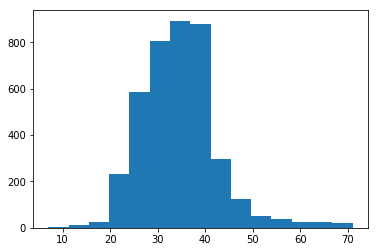

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(len_doc_lists, bins=15)

**Observation:**

As you can see in the histogram above is the distribution of the document length. Most of the documents has approximately the length of 35. This number is important for determine the max length of the document sequence. 

#### Task 12: Pad sequences to unique length
Next the [Keras function pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) shall be applied to represent the set of all sequences as a numpy-array. The number of rows in this array is the number of sequences, the number of columns is the fixed sequence length `maxlen`. Choose an appropriate value for the fixed sequence length. 

Moreover, the labels-list shall be one-hot-encoded into a numpy-array `labels` with two columns. In this array the entry in row i, column j is 1, if the i.th text belongs to the class with label j, otherwise this entry is 0.

In [31]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np 
from keras.utils import to_categorical

# textcorpus to sequences (WordEmbedding)
text_sequences = t.texts_to_sequences(texts)

# Word-Documents into sequences
doc_sequences =  pad_sequences(text_sequences, maxlen=35)

# labels into 2d array labels for Keras
categorical_label = to_categorical(labels, num_classes=2, dtype='float32')

### Split labeled texts in training- and validation set

#### Task 13: Create training- and validation-partition
The numpy-array of padded integer-sequences and the corresponding labels (as generated in the code cell above) shall be randomly shuffled and then split into a training- and a validation set. 80% of the labeled data is applied for training, the remaining 20% for validation. 

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_sequences,labels, test_size=0.2, random_state=123)

**Observation:**

Here we split `doc_sequences` and `labels` into training and test data sets.

### Load  and prepare Word-Embedding

#### Task 14: Load Word Embedding
Load the Word Embedding, which has been trained and saved in task 3.

In [33]:
from gensim.models import word2vec
modelName="./DataSets/dewiki2018skipgram.model"
w2v_model=word2vec.Word2Vec.load(modelName)

#### Task 15: Prepare `embeddings_index`
Next a Python dictionary `embeddings_index`, which maps words to their vector-representation must be generated.

In [34]:
embedding_index = embedding_index = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

/home/pia4/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


#### Task 16:  Prepare `embeddings_matrix`

The variable `word_index` has been allocated in **Task 10**. It maps each word of the labeled documents (news) to a unique index. Now `word_index` as calculated from the labeled input documents for the classifier is combined with the `embedding_index`, which maps each word of the word-embedding (German wikipedia dump in this case) to it's vector representation. The result is the *numpy-array* `embedding_matrix`, which contains in the i.th row the vector representation of the word with index i in the `word_index`. Applying this `embedding_matrix` allows the *Keras*-module `Embedding` to map a sequence of word-indices, which represents a single news-item, to a sequence of word-vectors. 

![wordMappings](./Pics/wordMappings.png)



In [35]:
EMBEDDING_DIM = 200

In [36]:
import numpy as np
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(23384, 200)

### Define CNN architecture, train and evaluate
In Keras network architectures can either be defined as [Sequential models](https://keras.io/getting-started/sequential-model-guide/) or by the [Functional API approach](https://keras.io/getting-started/functional-api-guide/). For the implementations in this lecture you are free to choose any of both. 

#### Task 17: Define CNN architecture
The `embedding_matrix`, as generated in the previous task shall now be assigned to the `weights`-argument of a [Keras Embedding Layer](https://keras.io/layers/embeddings/). The Embedding Layer constitutes the input layer of the CNN. 

Following the input layer configure one or more cascades of `Conv1D`-layers, followed by `MaxPooling1D`-layers. Apply `relu`-activation in the conv-layers. 


After the last convolutional-layer a `GlobalMaxPooling1D`-layer shall be applied, followed by a dense layer with softmax-activation (for the binary classification actually a sigmoid-activation at the output would be enough).

Display a summary of this architecture by calling the `summary()`-function.

In [38]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Activation, Conv1D, MaxPool1D, GlobalMaxPool1D

In [39]:
num_words = len(word_index)+1
EMBEDDING_MATRIX = embedding_matrix
MAX_SEQUENCE_LENGTH = 35

In [40]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[EMBEDDING_MATRIX], input_length=MAX_SEQUENCE_LENGTH))
#model.add(Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 200)           4676800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 128)           76928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            49280     
_________________________________________________________________
glob

#### Task 18: Define Training
Hyperparameters for training a Keras model are defined by applying the `compile()`-method. Use `binary_crossentropy` as loss-function, `rmsprop` as learning-algorithm (optimizer) and `accuracy` as metric. 

In [41]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Task 19:  Training and Validation
Apply the model's `fit()`-method for training. Assign training- and validation- data as generated in Task 13. Choose an appropriate `batch_size` and an appropriate number of `epochs`. 

After training is finished, plot the accuracy on the training- and validation-data over the epochs.

In [42]:
model.fit(X_train, y_train, epochs=10,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
3209/3209 [==============================] - 2s 583us/step - loss: 0.3214 - acc: 0.8620
Epoch 2/10
3209/3209 [==============================] - 1s 206us/step - loss: 0.1443 - acc: 0.9445
Epoch 3/10
3209/3209 [==============================] - 1s 206us/step - loss: 0.0733 - acc: 0.9760
Epoch 4/10
3209/3209 [==============================] - 1s 202us/step - loss: 0.0293 - acc: 0.9913
Epoch 5/10
3209/3209 [==============================] - 1s 204us/step - loss: 0.0084 - acc: 0.9975
Epoch 6/10
3209/3209 [==============================] - 1s 206us/step - loss: 0.0036 - acc: 0.9991
Epoch 7/10
3209/3209 [==============================] - 1s 202us/step - loss: 7.2810e-05 - acc: 1.0000
Epoch 8/10
3209/3209 [==============================] - 1s 208us/step - loss: 4.8447e-07 - acc: 1.0000
Epoch 9/10
3209/3209 [==============================] - 1s 204us/step - lo

In [43]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.15%


### Optimization
#### Task 20: Optimize CNN Architecture
Find a good CNN configuration by varying hyperparameters, such as number of layers, number of filters, filtersizes, etc. 


In [44]:
filters=264
kernel_size=5
pooling_strides=2

In [45]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[EMBEDDING_MATRIX], input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=filters, kernel_size=5, activation='relu'))
model.add(MaxPool1D(3, strides=pooling_strides))
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(MaxPool1D(3,strides=pooling_strides))
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 200)           4676800   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 31, 264)           264264    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 264)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 11, 264)           348744    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 264)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 264)            348744    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 264)               0         
__________

In [46]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10,batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
3209/3209 [==============================] - 1s 333us/step - loss: 0.3228 - acc: 0.8623
Epoch 2/10
3209/3209 [==============================] - 1s 210us/step - loss: 0.1433 - acc: 0.9442
Epoch 3/10
3209/3209 [==============================] - 1s 212us/step - loss: 0.0752 - acc: 0.9751
Epoch 4/10
3209/3209 [==============================] - 1s 210us/step - loss: 0.0176 - acc: 0.9935
Epoch 5/10
3209/3209 [==============================] - 1s 210us/step - loss: 0.0260 - acc: 0.9956
Epoch 6/10
3209/3209 [==============================] - 1s 212us/step - loss: 0.0048 - acc: 0.9984
Epoch 7/10
3209/3209 [==============================] - 1s 210us/step - loss: 9.4530e-05 - acc: 1.0000
Epoch 8/10
3209/3209 [==============================] - 1s 211us/step - loss: 2.0066e-07 - acc: 1.0000
Epoch 9/10
3209/3209 [==============================] - 1s 210us/step - loss: 1.1660e-07 - acc: 1.0000
Epoch 10/10
3209/3209 [==============================] - 1s 211us/step - loss: 1.1378e-07 - acc: 

## Conclusion

THe WordEmbedding model is very interesting it is also good to see the words laying in the vector space. It is interesting to see how good and even precise the similarities of the words are. 

The Gensim documentation is not that good, so we always had to try and search a lot. It was also not that easy to implement the `embedding_matrix`. 

As you can see in the first CNN modell, the training reached the 100% accuracy after 7 epochs and has an accuracy of 92.15% after the evaluation. 

After the second model we reached an accuracy of 92.40%. The change is `filters=264`, `kernel_size=5` and `pooling_strides=2`. 

## References
<sup>[1]</sup> [Python - Generator](https://www.python-kurs.eu/generatoren.php) 

<sup>[2]</sup> [Gensim - Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)